# Introduction

#_Brief Introduction to the project and its goals._#

# Setting up the Environment

### Importing Libraries

In [278]:
from dateutil import relativedelta

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Mike: Training Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Mike: Maths tools for CV param grids
from scipy.stats import uniform, truncnorm, randint

### Notebook Display Settings


In [279]:
# Change the maximum number of rows displayed when viewing the pandas dataframe
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import os
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Default Figure Settings

In [280]:
# Set plot properties
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)

# Choose the font for the plots based on os (as some fonts are not available across different os)
if os.name=='nt':
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['font.sans-serif'] = "Arial"
elif os.name=='posix':  
    mpl.rcParams['font.family'] = "Mukti Narrow"

# Enables colour codes for seaborn plots
sns.set(color_codes=True)

### Parallel Processing Configuration

In [281]:
import multiprocessing as mp

# Get the number of cpu available for parallel processing
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

## Read the Data

In [282]:
# Read the csv file 
data=pd.read_csv('Data/epl-training.csv')

# Dropping the trailing columns
data.dropna(axis=1, how='all',inplace=True)

# data['Date']=pd.to_datetime(data['Date'], format='%d/%m/%Y') #Mike: The new fmt causes some malfunctions
pd_dt_array = pd.to_datetime(data['Date'], format='%d/%m/%Y') #I haven't seen the neccessity for it, so I made a new array for it

data.drop([column for column in data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
print("Shape of the table (rows, columns): ", data.shape)
data.dtypes

Shape of the table (rows, columns):  (4180, 22)


Date        object
HomeTeam    object
AwayTeam    object
FTHG         int64
FTAG         int64
FTR         object
HTHG         int64
HTAG         int64
HTR         object
Referee     object
HS           int64
AS           int64
HST          int64
AST          int64
HF           int64
AF           int64
HC           int64
AC           int64
HY           int64
AY           int64
HR           int64
AR           int64
dtype: object

In [283]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


## Exploratory Data Analysis

### Check if there are duplicate or null value data.

In [284]:
print("Number of duplicate rows: ", data[data.duplicated()].shape[0])
print("Number of null blocks by colums:\n", data.isnull().sum(), sep='') #TODO: consider to plot it instead

Number of duplicate rows:  0
Number of null blocks by colums:
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64


As suggested by the output, we don't need to deal with null data nor duplicate rows in this dataset.

### Function definitions

The function __get_pivot_column_vs_column_count__ returns a dataframe after pivoting a column against another column. The elements of dataframe represent counts of all the different combinations of __col1__ and __col2__ in the dataframe __df__.

In [285]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

The function __get_column_countplot__ plots a bar chart. The bar chart is representative of the column __col__ in the dataframe __df__. The function counts the occurances of each value taken by __col__ in combination with the different outcome of __FTR__ (i.e. H, D, A). 

In [286]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

### Number of teams

#### Number of unique teams in the table:

In [287]:
data['HomeTeam'].nunique()

36

#### Checking if all the team in the column `HomeTeam` are in `AwayTeam`

In [288]:
np.array_equal(sorted(data['HomeTeam'].unique()),sorted(data['AwayTeam'].unique()))

True

#### List of all teams in the data:

In [289]:
print(sorted(data['HomeTeam'].unique()))

['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Brighton', 'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesbrough', 'Newcastle', 'Norwich', 'Portsmouth', 'QPR', 'Reading', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wolves']


### Analysing the `Referee` column

#### The number of unique referees in dataset:

In [290]:
data['Referee'].nunique()

36

> It can be seen that the number of referees here is the same as the number of teams

In [291]:
data['Referee'].nunique()==data['HomeTeam'].nunique()

True

### Analysing the Dates

The first and the last date (when arranged chronologically) observed in the table:

In [292]:
print("The earliest date in the table: ", pd_dt_array.min())
print("The latest date in the table: ", pd_dt_array.max())

The earliest date in the table:  2008-08-16 00:00:00
The latest date in the table:  2019-05-12 00:00:00


In [293]:
rd = relativedelta.relativedelta(pd_dt_array.max(),pd_dt_array.min())
print('%d years %d months %d days'%(rd.years,rd.months,rd.days))

10 years 8 months 26 days


In [294]:
sorted((pd_dt_array.dt.month).unique())

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12]

It can be seen here that 6 and 7 are missing.

> This means that no matches happen in June and July.

Therefore, we can consider that: 

> Each Season starts from __August to May__ and so we can deduce that the data covers __11 Seasons__

### Number of Matches played by the teams

A count of the occurances of each combination of Home and Away team allocation.

In [295]:
get_pivot_column_vs_column_count(data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,8.0,2.0,4.0,1.0,4.0,4.0,2.0,5.0,2.0,11.0,6.0,11.0,7.0,2.0,5.0,5.0,11.0,11.0,11.0,2.0,9.0,4.0,2.0,3.0,1.0,7.0,10.0,9.0,7.0,11.0,4.0,9.0,10.0,5.0,4.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,1.0,NaN,2.0,1.0,8.0,3.0,8.0,6.0,NaN,4.0,2.0,8.0,8.0,8.0,1.0,7.0,4.0,2.0,3.0,1.0,4.0,8.0,8.0,5.0,8.0,1.0,7.0,7.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,4.0,4.0,4.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,4.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,NaN,1.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,NaN,1.0
Burnley,5.0,2.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,5.0,4.0,5.0,2.0,2.0,3.0,4.0,5.0,5.0,5.0,1.0,3.0,NaN,1.0,1.0,NaN,4.0,4.0,3.0,3.0,5.0,3.0,3.0,5.0,1.0,2.0


Checking how many matches each team played. As every match a home team plays at home comes in conjunction with one it plays away, it is sufficient to count the number of home matches. 

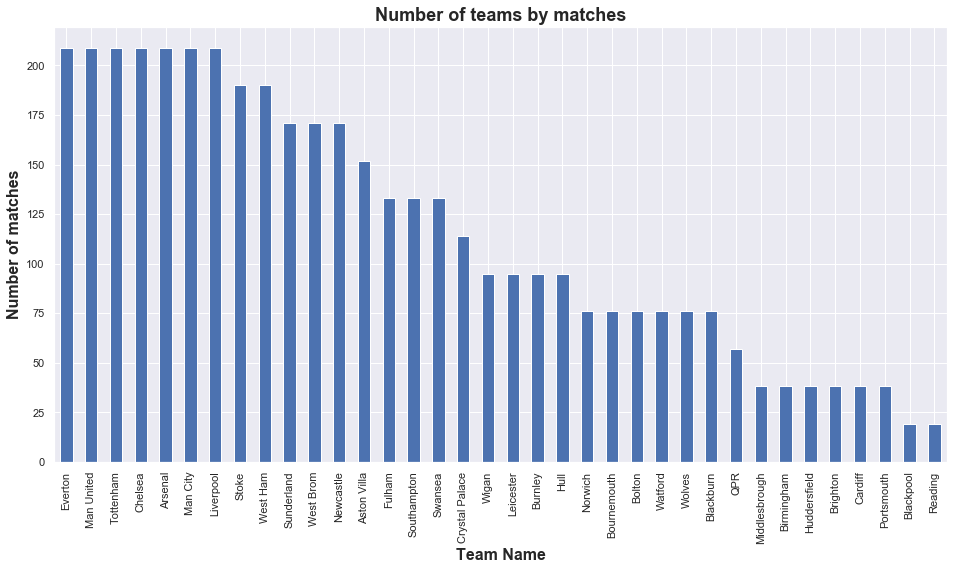

In [296]:
data.HomeTeam.value_counts().plot(kind='bar', figsize=(16,8))
plt.title('Number of teams by matches',fontsize=18, fontweight='bold')
plt.ylabel('Number of matches',fontsize=16, fontweight='bold')
plt.xlabel('Team Name',fontsize=16, fontweight='bold')
sns.set_style("white")
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
plt.show()

### HTR vs. FTR

A count plot to show the relationship between Half Time Result (`HTR`) and Full Time Result (`FTR`). This was done basically to check for how many of the matches the `HTR` and `FTR` result.

In [297]:
get_pivot_column_vs_column_count(data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,703,199,99
D,439,647,646
H,70,191,1186


###  Histogram (Count Plots) of all Features

The columns of the unprocessed dataset will later be used to extract information about the individual teams. To investigate the characteristics of each of the individual columns, we first utilize a histogram plot of each of the columns. Prior to obtaining this plot, all the categorical columns (Home Team, Away Team, Referee and Full Time Result) are turned into numerical values using the __Label_Encoder__ function.

Bar Chart for each of the numerical features in the imported dataset. The bar chart will show a count of the occurances of each unique value taken by each feautre. In addition to this, the bar chart will show what proportion of each unique value that resulted in Home win (__H__), Draw (__D__) or Away win (__A__).

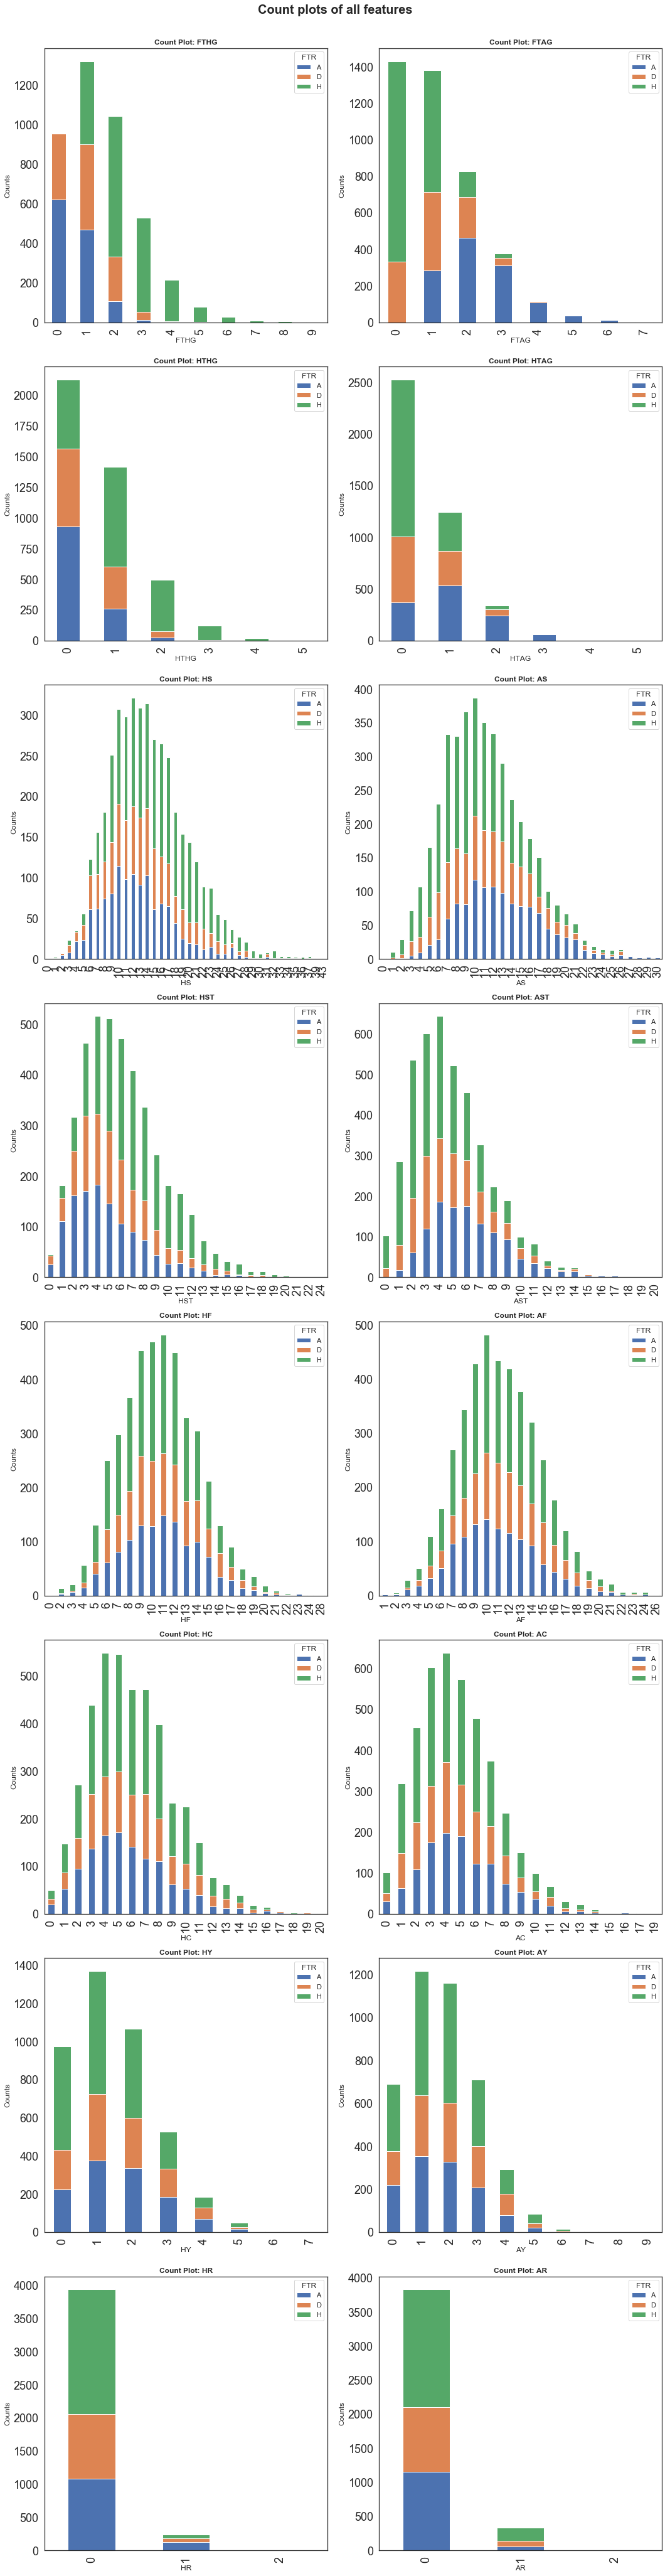

In [298]:
# Save the column names of numerical features as a list
num_col_list=[x for x in data.columns if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]

# Reshaping array for easier formatting
num_col_list = np.reshape(num_col_list, (8, 2))

# Call the function get_column_countplot() to plot the count plot of the categorical columns as s ubplots in a figure
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i in range(8):
    for j in range(2):
        get_column_countplot(data,num_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
sns.set_style("white")
plt.show()

### Checking if the dataset is balanced

A bar chart showing the number of home wins, draws and away wins.

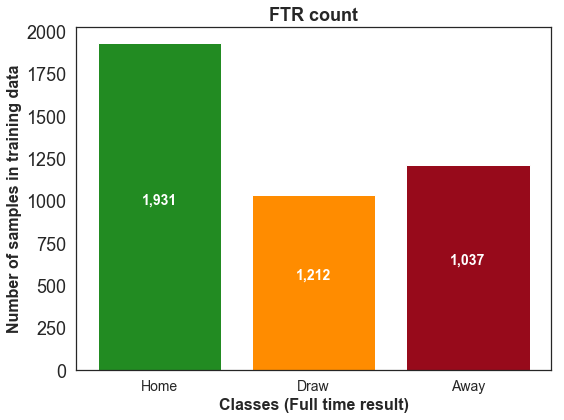

In [299]:
# Get the counts 
count_val=data['FTR'].value_counts()

# Visualise the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom', fontweight='bold', fontsize=14)
ax.set_title('FTR count', fontsize=18, fontweight='bold')
ax.set_xlabel('Classes (Full time result)', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of samples in training data', fontsize=16, fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
sns.set_style("white")
plt.show()

#### Encoding the non-numerical columns

In [300]:
encoded_data = data.copy()

for column in ['HomeTeam','AwayTeam','Referee','FTR','HTR']:
    encoded_data[column] = LabelEncoder().fit_transform(encoded_data[column])

### Correlation Matrix of the Raw Data

A visual plot of the correlation matrix between the all the raw columns of the provided dataset. This will help identify important columns as well as discard those that show no correlation. For this, the label encoded dataset will be utilized.

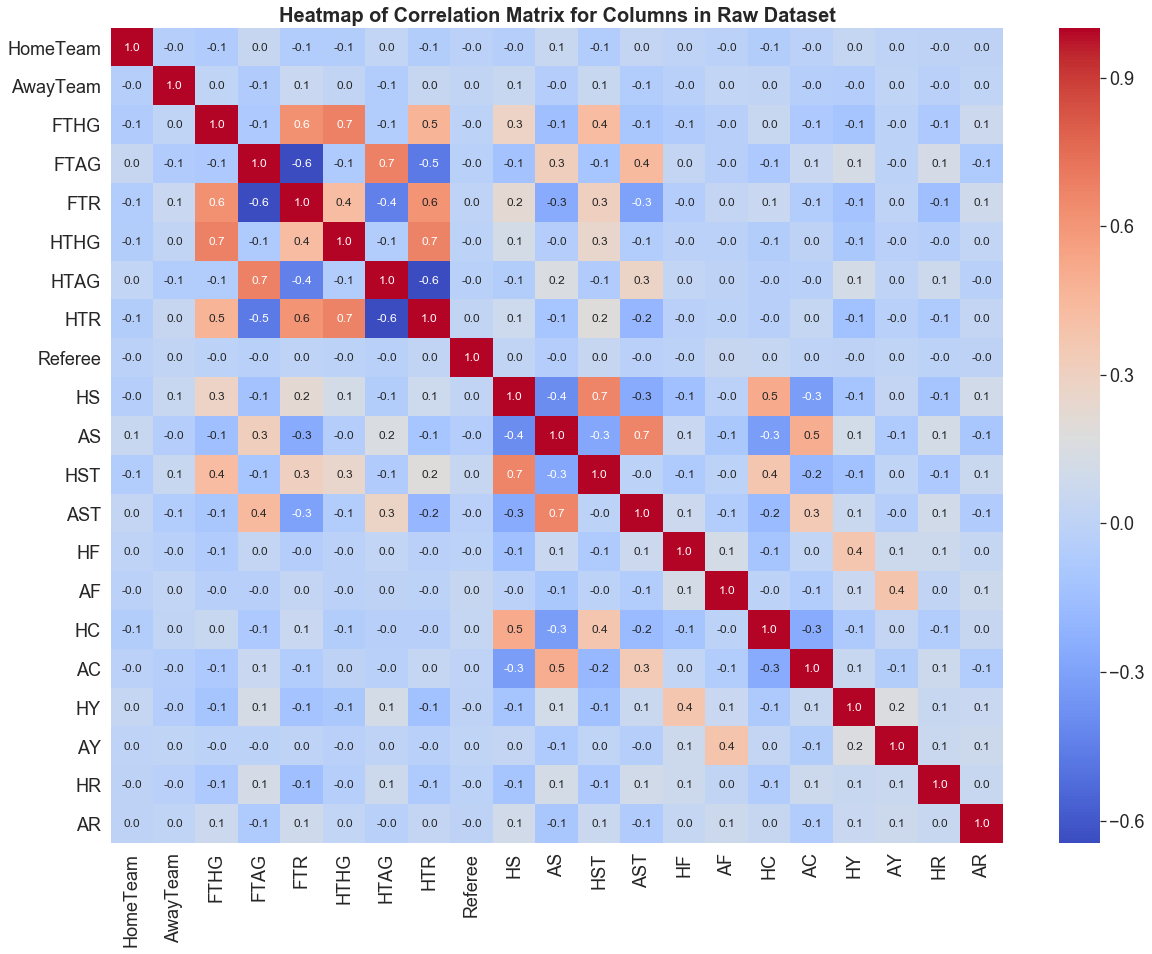

In [301]:
fig=plt.figure(figsize=(20,15))
ax = plt.subplot()
ax.set_title("Heatmap of Correlation Matrix for Columns in Raw Dataset",fontsize=20,fontweight='bold')
sns.heatmap(encoded_data.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax)
plt.show()

### Mean, Percentiles and Trimming of Data

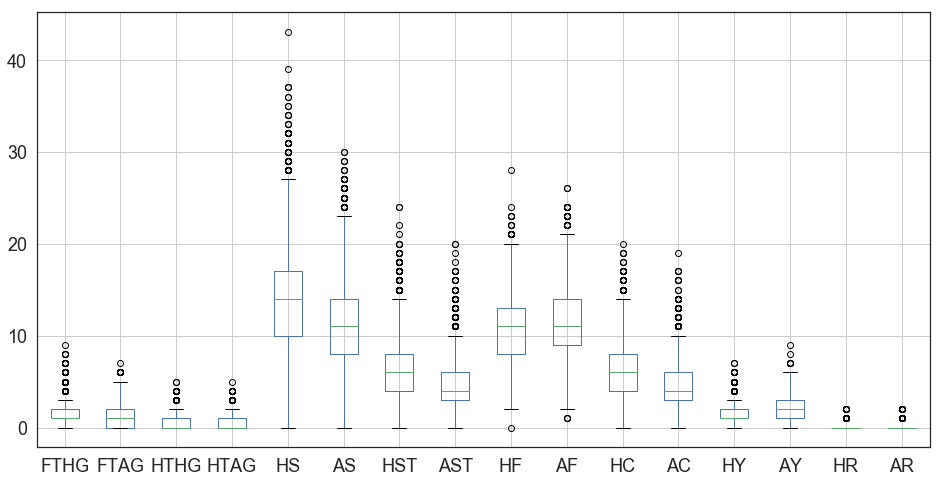

In [302]:
data.boxplot(figsize=(16,8));

We can see that there are considerable amount of outliers for some features. This can be caused by such as very strong team scores a lot against a very weak team. These kinds of outliers can introduce bias, which influence out prediction performance.

Let's implement a function to trim it.

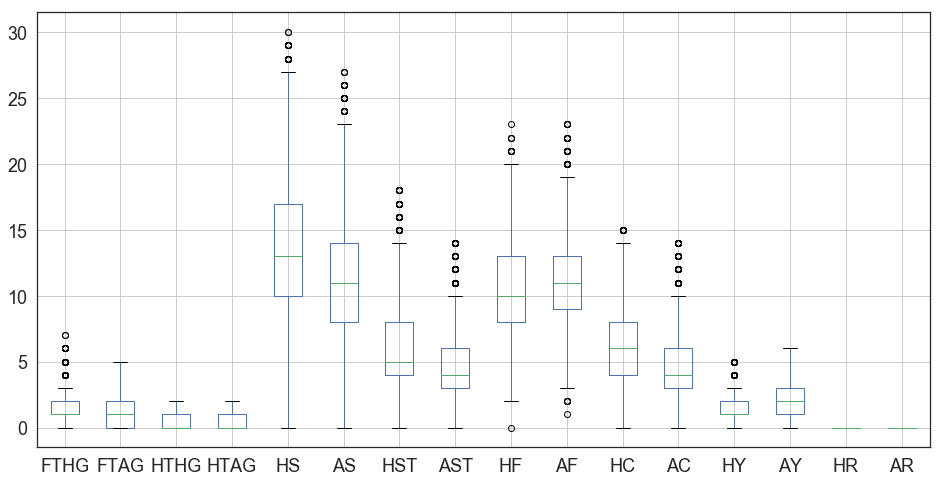

In [303]:
def trim_data(data, q1 = 0.25, q2 = 0.75):
    Q1 = data.quantile(q1); Q3 = data.quantile(q2);
    IQR = Q3 - Q1
    data_trimmed = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data_trimmed

q1 = 0.2
q2 = 0.8
data_trimmed = trim_data(data, q1, q2)
data_trimmed.boxplot(figsize=(16,8));

We set the quantile range of 0.2 ~ 0.8 in this case. Cause trimming causes loss of valuable data. From the above figure, we can indeed see the outliers are reduced.

Let's see how much data was lost by setting this threshold range.

In [304]:
rows_org = int(data.shape[0])
rows_trimmed = int(data_trimmed.shape[0])
loss = rows_org - rows_trimmed

print('Loss of data:{} Percentage:{:.1f}%'.format(loss, 100 * loss/rows_org),
      '\nOld Data Numbers:', rows_org,
      '\nNew Data Numbers:', rows_trimmed
     )

Loss of data:855 Percentage:20.5% 
Old Data Numbers: 4180 
New Data Numbers: 3325


Thus, there is a trade-off here. Let's keep the original data for now, and compare if trimming can improve perfomance after we train the original data.

# Feature Extraction

### Average Goals, Points and Aggressiveness

Calculating average goals and scores for home teams and away teams. The scores are calculated by considering a win as 3 points, a draw as 1 point and a loss as 0 points. As the number of goals conceded by one team is the number of goals scored by the other team, the average number of goals conceded by the home team is equal to the number of goals scored by the away team (the same applies for goals conceded by the away team). These average values will be used to scale metrics later on in feature extraction to ensure that a value of 1 represents an average performance. This will ensure that the features are of similar scale. 

In [305]:
# Get total number of matches
num_matches = data.shape[0] 

# Sum home goals column, divide by total matches
average_home_goals = data.FTHG.sum()/num_matches

# Sum away goals column, divide by total matches
average_away_goals = data.FTAG.sum() /num_matches

# Average conceded goals = Average of goals for opposite team
avg_home_conceded = average_away_goals 
avg_away_conceded = avg_home_conceded

# Calculating points for each team
average_home_points = (3*count_val['H'] + count_val['D'])/num_matches
average_away_points = (3*count_val['A'] + count_val['D'])/num_matches

# Calculating other average  home and away
average_home_yellow = data.HY.sum()/num_matches
average_away_yellow = data.AY.sum()/num_matches
average_home_red = data.HR.sum()/num_matches
average_away_red = data.AR.sum()/num_matches
average_home_fouls = data.HF.sum()/num_matches
average_away_fouls = data.AF.sum()/num_matches

print('Average Home Goals:', average_home_goals)
print('Average Away Goals:', average_away_goals)
print('Average Home Points:',average_home_points)
print('Average Away Points:', average_away_points)
# print('Average Home Yellow Cards:', average_home_yellow)
# print('Average Away Yellow Cards:', average_away_yellow)
# print('Average Home Red Cards:',average_home_red)
# print('Average Away Red Cards:', average_away_red)
print('Average Home Fouls:',average_home_fouls)
print('Average Away Fouls:', average_away_fouls)

Average Home Goals: 1.555023923444976
Average Away Goals: 1.1708133971291865
Average Home Points: 1.6339712918660287
Average Away Points: 1.1179425837320573
Average Home Fouls: 10.682057416267943
Average Away Fouls: 11.204306220095694


### Team Statistics

Features in the raw data may be used to compute metrics that quantify different qualities of each team when they are playing at home and away. These quantities will be the same for all the home/away matches they play (i.e. a team will have the same Home Attacking Strength (HAS) for all games that it plays on home turf).

In [306]:
team_stats= pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS','HS','HST','AS','AST','HCON','ACON','HF','AF','HAGG','AAGG'))

In [307]:
# Group data by the teams
res_home = data.groupby('HomeTeam')
res_away = data.groupby('AwayTeam')

In [308]:
# Add the list of team names
team_stats.Team = pd.Series(data['HomeTeam'].unique())

In [309]:
# Home goal scored (HGS)
team_stats.HGS = res_home.FTHG.sum().values 
# Home goal conceded (HGC)
team_stats.HGC = res_home.FTAG.sum().values

In [310]:
# Away goal scored (AGS)
team_stats.AGS = res_away.FTAG.sum().values 
# Away goal conceded (AGC)
team_stats.AGC = res_away.FTHG.sum().values 

In [311]:
# Calculate number of games played
total_home_games_played = res_home.FTHG.count()
total_away_games_played = res_away.FTAG.count()

In [312]:
# Home Attacking Strength
team_stats.HAS = (np.divide(team_stats.HGS,total_home_games_played.values)) / average_home_goals
# Away Attacking Strength
team_stats.AAS = (np.divide(team_stats.AGS,total_away_games_played.values)) / average_away_goals

In [313]:
# Home Defensive Strength
team_stats.HDS = (np.divide(team_stats.HGC,total_home_games_played.values)) / avg_home_conceded
# Away Defensive Strength
team_stats.ADS = (np.divide(team_stats.AGC,total_away_games_played.values)) / avg_away_conceded

In [314]:
# Obtaining for each team: Average number of goals scored and conceded when at home and at away.
team_stats.GSA = (np.divide(team_stats.AGS,total_away_games_played.values))
team_stats.GSH = (np.divide(team_stats.HGS,total_home_games_played.values))

team_stats.GCA = (np.divide(team_stats.AGC,total_away_games_played.values))
team_stats.GCH = (np.divide(team_stats.HGC,total_home_games_played.values))

In [315]:
# Shots taken at home and away
team_stats.HS = res_home.HS.sum().values 
team_stats.AS = res_away.AS.sum().values

# Shots taken on target at home and away
team_stats.HST = res_home.HST.sum().values 
team_stats.AST = res_away.AST.sum().values

# Shot conversion rate (accuracy) at home and away
team_stats.HCON = (np.divide(team_stats.HST,team_stats.HS)) 
team_stats.ACON = (np.divide(team_stats.AST,team_stats.AS)) 

In [316]:
# Total number of fouls at home and away
team_stats.HF = res_home.HF.sum().values 
team_stats.AF = res_away.AF.sum().values

# A measure of aggressiveness for each team
team_stats.HAGG = (np.divide(team_stats.HF,total_home_games_played.values)) / average_home_fouls
team_stats.AAGG = (np.divide(team_stats.AF,total_away_games_played.values)) / average_away_fouls

In [317]:
team_stats.head()

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS,HS,HST,AS,AST,HCON,ACON,HF,AF,HAGG,AAGG
0,Arsenal,441,356,1.356923,1.454843,174,292,0.711075,1.193298,3448,1641,2724,1276,0.475928,0.468429,2137,2134,0.957201,0.911304
1,Bolton,179,156,0.757308,0.876584,198,264,1.112587,1.483449,1804,812,1478,693,0.450111,0.468877,1639,1825,1.009440,1.071604
2,Everton,38,37,0.643077,0.831631,35,70,0.786678,1.573355,379,186,321,189,0.490765,0.588785,390,417,0.960785,0.979417
3,Hull,98,77,0.829231,0.865345,90,162,1.011443,1.820597,949,501,689,385,0.527924,0.558781,957,950,1.178809,1.115642
4,Middlesbrough,30,25,1.015385,1.123825,37,41,1.663261,1.843073,253,134,193,101,0.529644,0.523316,216,187,1.064254,0.878422


Not all the features in the table above will be used in the final input features of the classifier. Some of these statistics are intermediate values which aided in the calculation of other statistics. For example the __HGS__ column was used to compute the __HAS__ column. 

### Calculation of Form

Form is a calculation of a team's recent performance. Additionally these statistics vary with different allocations. (i.e. a team may have different __FFPTSH__ for different matches played at home). The function __get_features_match__ takes a match info and number of matches as inputs. The function then finds the number of past matches where the two teams played each other. If __n__ or more such matches exist, then the function computes 3 quantities: __FFPTSH__: Average points of home team in the past n matches against the away team, __FFHG__: Average goals of away team against home team in past n matches and __FFAG__: Average goals of home team against away team in the past n matches. If no matches are found then, the average quantities for these statistics are used. 

In [318]:
def get_features_match(match, n=5):
    team1 = match['HomeTeam']
    team2 = match['AwayTeam']
    # Constructing a table when all the matches between the two teams are shown.
    res = data[((data['HomeTeam']==team1) & (data['AwayTeam']==team2)) | ((data['AwayTeam']==team1) & (data['HomeTeam']==team2))]
    name = match.name
    idx = res.index.get_loc(name)
    if idx >= n: #If there is at least n matches between the teams
        matches = res.iloc[idx-n:idx]
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if row['FTR'] == 'H':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if row['FTR'] == 'A':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
        pts_avg = pts_home/n
        goals_home_avg = goals_home/n
        goals_away_avg = goals_away/n
    elif idx == 0: # If there is 0 matches between the teams
        pts_avg = average_home_points
        goals_home_avg = average_home_goals
        goals_away_avg = average_away_goals
    else: #Some games between the teams but not n
        matches = res.iloc[0:idx]
        m = len(matches)
        pts_home = 0
        goals_home = 0
        goals_away = 0
        for index, row in matches.iterrows():
            #This ifs control if the current home team was home team or away in the past matches between the team in order
            #to sum correctly home/away goals. 
            if row['HomeTeam'] == team1:
                goals_home += row['FTHG']
                goals_away += row['FTAG']
                if row['FTR'] == 'H':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
            if row['AwayTeam'] == team1:
                goals_home += row['FTAG'] 
                goals_away += row['FTHG']
                if row['FTR'] == 'A':
                    pts_home += 3
                elif row['FTR'] == 'D':
                    pts_home += 1
        pts_avg = pts_home/m
        goals_home_avg = goals_home/m
        goals_away_avg = goals_away/m
    return pts_avg, goals_home_avg, goals_away_avg


Another measure of form is the winning streak of the team. The fucntion __get_features_streak_home__ takes match info and the number of matches to consider as the inputs. It computes three quantities: __PSH__ the point streak of the home team, __SSH__ the average goals over the past __n__ games for the home team and __CSH__ the average goals conceded over the past __n__ matches for the home team. A similar function called __get_features_streak_away__ does the same for the away team. 

In [319]:
def get_features_streak_home(match, n=15):
    team1 = match['HomeTeam']
    team1_stats = data[((data['HomeTeam']==team1) | (data['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if row['FTR'] == 'H':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if row['FTR'] == 'A':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

In [320]:
def get_features_streak_away(match, n=15):
    team1 = match['AwayTeam']
    team1_stats = data[((data['HomeTeam']==team1) | (data['AwayTeam']==team1))]
    name = match.name
    idx = team1_stats.index.get_loc(name)
    if idx == 0:
        pts_avg = average_home_points
        goals_scored_avg = average_home_goals
        goals_conceded_avg = average_away_goals
    else:
        if idx-n < 0:
            newidx = 0
        else:
            newidx = idx - n
        matches_team1 = team1_stats.iloc[newidx:idx]
        m = len(matches_team1)
        pts = 0
        goals_scored = 0
        goals_conceded = 0
        for index, row in matches_team1.iterrows():
            if row['HomeTeam'] == team1:
                goals_scored += row['FTHG']
                goals_conceded += row['FTAG']
                if row['FTR'] == 'H':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
            if row['AwayTeam'] == team1:
                goals_scored += row['FTAG'] 
                goals_conceded += row['FTHG']
                if row['FTR'] == 'A':
                    pts += 3
                elif row['FTR'] == 'D':
                    pts += 1
        pts_avg = pts/m
        goals_scored_avg = goals_scored/m
        goals_conceded_avg = goals_conceded/m
    return pts_avg, goals_scored_avg, goals_conceded_avg

# Data Pre-Processing

### Defining Input Features and Output Labels

The input features are the features that will eventually be used to train the classifier. Additionally the labels are the observed outcomes. The labels will be used to find the error in the classifier and thereby train the classifier. The function __match_with_team_stats__ add rows from the table __team_stats__ onto the table __X__ according to the value taken by __left_on__. This will be used to add team statistics of the home and away team as features. The __build_X__ function takes inputs of two tables __X__ and __team_stats__. It returns a complete table representing the full feature matrix that will be used to train and test models.

In [321]:
def match_with_team_stats(X,team_stats,col_to_add,left_on,right_on='Team'):
    X=pd.merge(X,team_stats[[right_on,col_to_add]],how='left',left_on=left_on,right_on=right_on,sort=False).\
                                                                                    drop(right_on, axis = 1) 
    return X

In [322]:
def build_X(X,team_stats):
    # Add Home Attacking Strength(HAS), Home Defensive Strength(HDS), Away Attacking Strength(AAS), 
    # Away Defensive Strength(ADS)
    X = match_with_team_stats(X,team_stats,'HAS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HDS','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HCON','HomeTeam')
    X = match_with_team_stats(X,team_stats,'HAGG','HomeTeam')
    
    X = match_with_team_stats(X,team_stats,'AAS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ADS','AwayTeam')
    X = match_with_team_stats(X,team_stats,'ACON','AwayTeam')
    X = match_with_team_stats(X,team_stats,'AAGG','AwayTeam')
    
    # Add Home Shots on Target(HST), Away Shots on Target(AST), Home Corners(HC), Away Corners(AC) ??
    X[['FFPTSH','FFHG','FFAG']] = X.apply(get_features_match, axis=1, result_type='expand')
    X[['PSH','SSH','CSH']] = X.apply(get_features_streak_home, axis=1, result_type='expand')
    X[['PSA','SSA','CSA']] = X.apply(get_features_streak_away, axis=1, result_type='expand')
    
    return X

In [323]:
X = data[['HomeTeam', 'AwayTeam']]
X = build_X(X,team_stats)


In [324]:
# X.loc[X['HomeTeam'] == 'Everton'].loc[X['AwayTeam'] == 'Arsenal'].head(20)gc
X.tail()

,HomeTeam,AwayTeam,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
4175,Liverpool,Wolves,1.101538,0.919493,0.442366,1.014983,0.472007,1.505926,0.384393,1.129735,2.400000,2.000000,0.400000,2.466667,2.466667,0.800000,1.866667,1.600000,1.066667
4176,Man United,Cardiff,0.693846,1.640785,0.310044,0.891805,1.356763,1.144258,0.455481,0.971516,2.333333,3.000000,1.000000,1.666667,1.400000,1.333333,0.800000,0.866667,1.866667
4177,Southampton,Huddersfield,0.752137,1.073877,0.426641,1.024837,0.842869,1.505926,0.474432,1.036960,1.666667,1.333333,0.666667,1.266667,1.400000,1.666667,0.266667,0.533333,2.533333
4178,Tottenham,Everton,0.724308,1.303637,0.396022,1.162796,0.831631,1.573355,0.588785,0.979417,2.600000,3.400000,1.000000,1.466667,1.266667,1.000000,1.533333,1.266667,0.866667
4179,Watford,West Ham,0.913846,1.159787,0.408699,0.980986,0.977728,1.652023,0.345367,0.829099,2.000000,1.800000,1.000000,1.200000,1.266667,1.533333,1.200000,1.200000,1.466667


In [325]:
y = data[['FTR']]

y.head()

,FTR
0,H
1,H
2,A
3,H
4,H


### By now, let's implement a look-up for teams' abilities

Let consider the lateast few match-ups of individual team's ability value against each other, since we are more interested in quantifying how good they perform against each other, instead of the team name. 

These ability values are also the ones we will be using to classify during trainning.

In [326]:
X_c1 = X.copy() #Mike: savepoint

In [332]:
X = X_c1.copy()
X.groupby('HomeTeam').head()

,HomeTeam,AwayTeam,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,Arsenal,West Brom,1.356923,0.711075,0.475928,0.957201,1.132816,1.393543,0.354308,0.995858,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
1,Bolton,Stoke,0.757308,1.112587,0.450111,1.009440,0.539436,1.753167,0.334286,0.991160,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
2,Everton,Blackburn,0.643077,0.786678,0.490765,0.960785,1.373110,0.907233,0.430759,0.938207,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
3,Hull,Fulham,0.829231,1.011443,0.527924,1.178809,1.011443,1.296145,0.316176,1.069451,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
4,Middlesbrough,Tottenham,1.015385,1.663261,0.529644,1.064254,0.665304,1.600327,0.382812,1.078533,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3478,Brighton,Newcastle,0.717538,1.276665,0.537209,1.110569,0.667873,1.387121,0.489378,0.987134,1.633971,1.555024,1.170813,0.800000,0.800000,1.400000,1.466667,1.466667,1.066667
3482,Huddersfield,Tottenham,0.761538,1.303637,0.494080,0.975566,0.665304,1.600327,0.382812,1.078533,1.633971,1.555024,1.170813,1.500000,0.833333,0.500000,2.333333,2.600000,0.666667
3497,Brighton,Everton,0.717538,1.276665,0.537209,1.110569,0.831631,1.573355,0.588785,0.979417,1.633971,1.555024,1.170813,1.000000,0.714286,1.285714,1.200000,0.933333,1.533333
3502,Huddersfield,Man United,0.761538,1.303637,0.494080,0.975566,0.561913,1.573355,0.291005,0.854934,1.633971,1.555024,1.170813,1.125000,0.625000,1.125000,1.933333,1.800000,0.466667


In [328]:
#Mike: it takes the recent 3 matchups abi data for H vs A and work out the mean.
# Assume Each Team Has At Least 3 Matchups Against Each Other !
def lookup_simple(X, HomeTeam, AwayTeam):
    return X.loc[X['HomeTeam'] == HomeTeam].loc[X['AwayTeam'] == AwayTeam].tail(3).mean(axis=0)

lookup_simple(X, 'Arsenal', 'West Brom')

HAS       1.356923
HDS       0.711075
HCON      0.475928
HAGG      0.957201
AAS       1.132816
ADS       1.393543
ACON      0.354308
AAGG      0.995858
FFPTSH    2.066667
FFHG      1.733333
FFAG      0.866667
PSH       1.955556
SSH       1.911111
CSH       1.044444
PSA       1.177778
SSA       1.022222
CSA       1.177778
dtype: float64

### Label Encoding Categorical Columns

In [336]:
#Mike: I simply removed it since our implementation performs lookup for teamname, 
#and teamname is not one of the input features
# for column in ['HomeTeam','AwayTeam']:
#     X[column] = LabelEncoder().fit_transform(X[column])
X = X[[c for c in X.columns if c not in ['HomeTeam', 'AwayTeam']]]


# y = LabelEncoder().fit_transform(y) # Mike:old implementation for y

# Mike: I still feel like this could be better for FTR
def encodeHDA(e):
    if str(e) not in 'HDA': 
        return e

    d = {
        'H':1,
        'D':0,
        'A':-1
    }
    return d.get(e)

y['FTR'] = y['FTR'].map(encodeHDA)
X.head()

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,1.356923,0.711075,0.475928,0.957201,1.132816,1.393543,0.354308,0.995858,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
1,0.757308,1.112587,0.450111,1.009440,0.539436,1.753167,0.334286,0.991160,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
2,0.643077,0.786678,0.490765,0.960785,1.373110,0.907233,0.430759,0.938207,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
3,0.829231,1.011443,0.527924,1.178809,1.011443,1.296145,0.316176,1.069451,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813
4,1.015385,1.663261,0.529644,1.064254,0.665304,1.600327,0.382812,1.078533,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813,1.633971,1.555024,1.170813


### Exploratory Data Analysis on Engineered Features

A histogram plot of the number of occurances of the different values of each features.

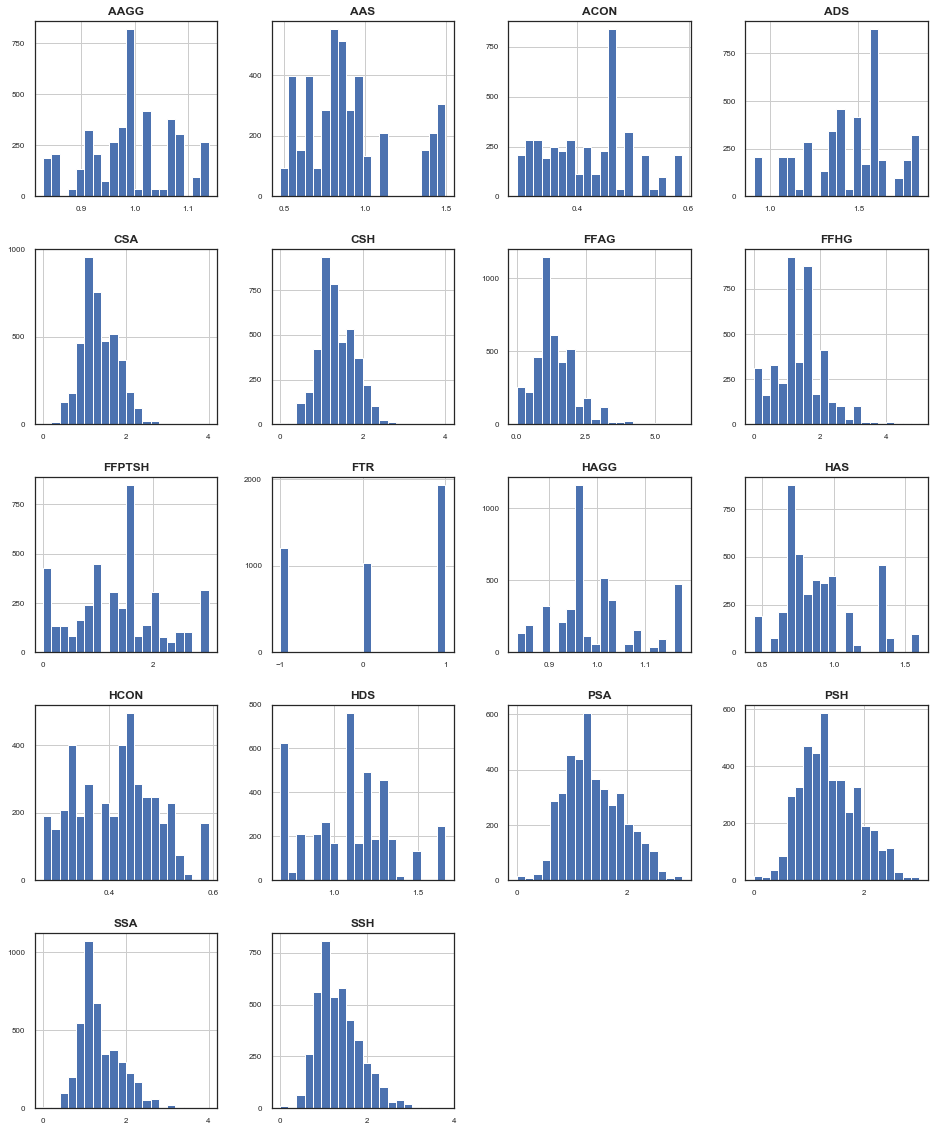

In [337]:
data_for_cor = X.copy() #Mike: not mass up with the X referencing object
data_for_cor['FTR'] = y

data_for_cor.hist(figsize=(16, 20), bins=20, xlabelsize=8, ylabelsize=8)
sns.set_style("white")

#### Correlation plot for Engineered Features

Similar to the correlation matrix plot for the raw column data, this plot visualizes the correlation between the engineered featuers, the competing teams and the full time result. This is represented on a heatmap.

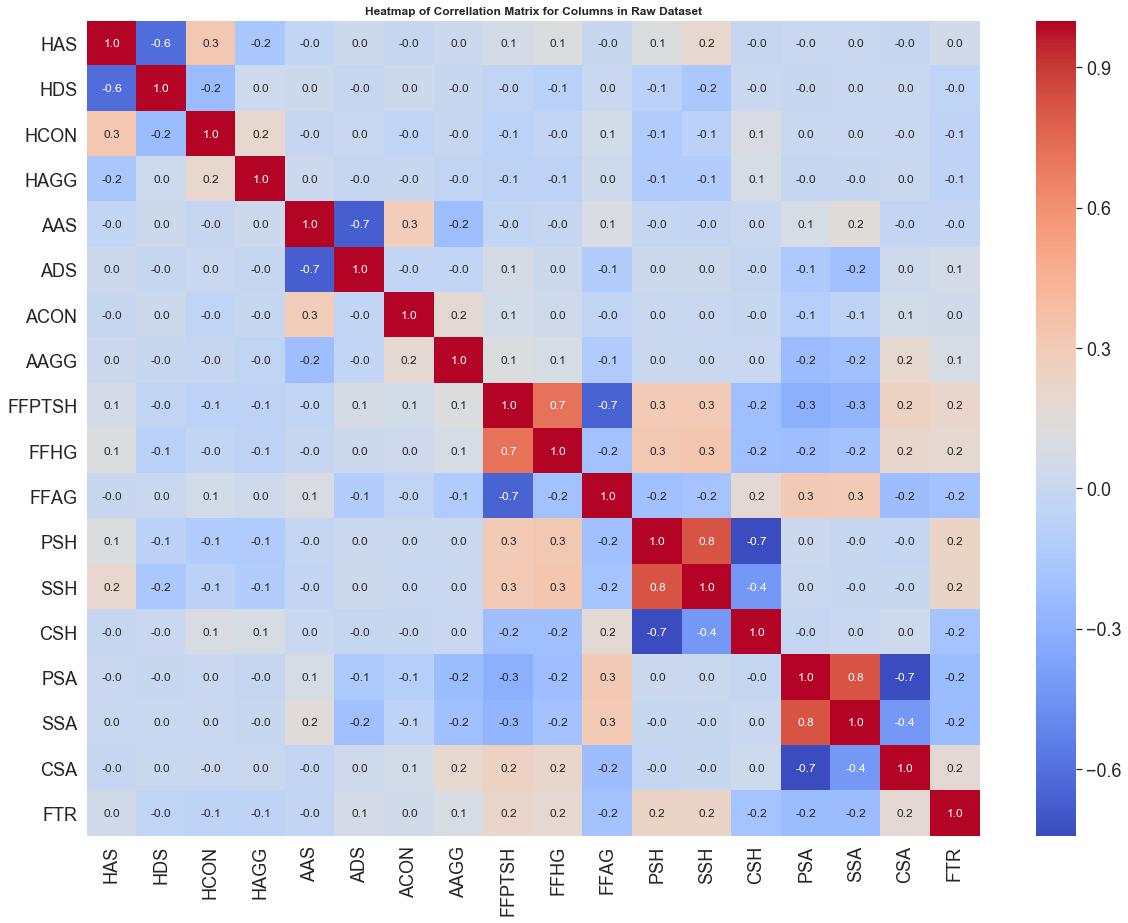

In [338]:
plt.figure(figsize=(20,15))
ax = plt.subplot(111)
ax.set_title("Heatmap of Correllation Matrix for Columns in Raw Dataset")
sns.heatmap(data_for_cor.corr(), annot = True, fmt='.1f', cmap= 'coolwarm', ax=ax);

### Scaling the features

In [339]:
X_c = X.copy() #Mike: savepoint

In [340]:
X = X_c.copy()

# Mike: remove Teams since look-up will be performed for end predictions
# X = X[[column for column in X.columns if column not in ['HomeTeam', 'AwayTeam']]] 

scaler = MinMaxScaler() #Mike: popular opts: {StandardScaler, MinMaxScaler, RobustScaler, Normalizer}
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

X_scaled

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
0,0.790451,0.033195,0.636545,0.359754,0.642942,0.519651,0.212582,0.539924,0.544657,0.311005,0.195136,0.544657,0.409217,0.292703,0.544657,0.388756,0.292703
1,0.273541,0.440871,0.555493,0.510676,0.065606,0.903930,0.145344,0.524715,0.544657,0.311005,0.195136,0.544657,0.409217,0.292703,0.544657,0.388756,0.292703
2,0.175066,0.109959,0.683125,0.370107,0.876740,0.000000,0.469319,0.353267,0.544657,0.311005,0.195136,0.544657,0.409217,0.292703,0.544657,0.388756,0.292703
3,0.335544,0.338174,0.799783,1.000000,0.524851,0.415575,0.084530,0.778200,0.544657,0.311005,0.195136,0.544657,0.409217,0.292703,0.544657,0.388756,0.292703
4,0.496021,1.000000,0.805183,0.669039,0.188072,0.740611,0.308306,0.807605,0.544657,0.311005,0.195136,0.544657,0.409217,0.292703,0.544657,0.388756,0.292703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,0.570292,0.244813,0.531177,0.526690,0.000000,0.639738,0.313614,0.973384,0.800000,0.400000,0.066667,0.822222,0.649123,0.200000,0.622222,0.400000,0.266667
4176,0.218833,0.977178,0.115760,0.170819,0.860835,0.253275,0.552339,0.461113,0.777778,0.600000,0.166667,0.555556,0.368421,0.333333,0.266667,0.216667,0.466667
4177,0.269083,0.401568,0.481811,0.555160,0.360835,0.639738,0.615981,0.673004,0.555556,0.266667,0.111111,0.422222,0.368421,0.416667,0.088889,0.133333,0.633333
4178,0.245093,0.634855,0.385683,0.953737,0.349901,0.711790,1.000000,0.486692,0.866667,0.680000,0.166667,0.488889,0.333333,0.250000,0.511111,0.316667,0.216667


### Splitting into training and testing datasets

Splitting the full list of input features into training and testing datasets. The output labels are also split accordingly. The decided splitting ratio is 1:4 (test:train).

In [341]:
size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = size, random_state=42)

print([_.shape for _ in [X_train, X_test, y_train, y_test]])
X_train

[(3344, 17), (836, 17), (3344, 1), (836, 1)]


,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
2176,0.618037,0.053942,0.590579,0.310579,0.524851,0.415575,0.084530,0.778200,1.000000,0.400000,0.166667,0.200000,0.140351,0.483333,0.244444,0.283333,0.633333
816,0.452255,0.657676,0.212085,0.085409,0.188072,0.740611,0.308306,0.807605,0.000000,0.050000,0.291667,0.200000,0.245614,0.566667,0.644444,0.383333,0.300000
2222,0.446002,0.347955,0.264435,0.514489,0.642942,0.519651,0.212582,0.539924,0.600000,0.360000,0.133333,0.288889,0.192982,0.366667,0.311111,0.316667,0.433333
1185,0.252874,0.437068,0.152550,0.702254,0.904573,0.196507,0.553792,0.438991,0.333333,0.320000,0.333333,0.444444,0.403509,0.333333,0.755556,0.533333,0.200000
776,1.000000,0.008299,0.563351,0.399871,0.284294,0.731004,0.278288,0.348289,0.250000,0.200000,0.500000,0.266667,0.192982,0.566667,0.755556,0.850000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.433498,0.510966,0.743616,0.339603,0.492048,0.795852,0.182557,0.000000,0.600000,0.280000,0.166667,0.288889,0.315789,0.400000,0.288889,0.250000,0.466667
466,0.411730,0.452282,0.466404,0.521945,0.382704,0.687773,0.793053,1.000000,0.544657,0.311005,0.195136,0.259259,0.175439,0.305556,0.444444,0.350000,0.400000
3092,0.570292,0.244813,0.531177,0.526690,0.382704,0.975983,0.899240,0.927757,0.333333,0.120000,0.133333,0.577778,0.543860,0.350000,0.333333,0.216667,0.350000
3772,0.452255,0.657676,0.212085,0.085409,0.904573,0.196507,0.553792,0.438991,0.266667,0.240000,0.400000,0.400000,0.403509,0.466667,0.777778,0.633333,0.216667


# Model Training

#### Functions to train the classifiers

In [342]:
def get_scores(model,X,y):
    '''
    Parameters:
        model
        X
        y
    
    Returns:
    '''
    scores = cross_validate(model, X, y, scoring=('accuracy','f1_macro','precision_macro','recall_macro','roc_auc_ovr'),
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    print('Accuracy: %f'%(scores['test_accuracy'].mean()))
    print('Precision: %f'%(scores['test_precision_macro'].mean()))
    print('Recall: %f'%(scores['test_recall_macro'].mean()))
    print('f1 Score: %f'%(scores['test_f1_macro'].mean()))
    print('ROC-AUC: %f'%(scores['test_roc_auc_ovr'].mean()))
    return scores

In [343]:
def get_best_params_RandomizedCV(model,param_grid,X,y,refit='accuracy'):
    '''
    This function executes the RandomizedSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
        model
        X
        y
        param_grid
        refit='accuracy'
    
    Returns:
        grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best parameters: \n',grid_results.best_params_)
    return grid_results.best_params_

In [344]:
def get_best_params_GridCV(model,param_grid,X,y,refit='accuracy'):
    '''
    This function executes the GridSearchCV() to tune the 
    hyperparameters, prints the best scores and returns the list of 
    best performing hyperparameters.
    
    Parameters:
    model
    X
    y
    param_grid
    refit='accuracy'
    
    Returns:
    grid_results.best_params_ (dictionary):
    '''
    scoring=('accuracy','f1_macro','roc_auc_ovr')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = GridSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, y)
    cv_results=grid_results.cv_results_
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best mean %s Score: '%(other_scores[0]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best mean %s Score: '%(other_scores[1]),cv_results['mean_test_%s'%(other_scores[0])][best_index_results])
    print('Best parameters: \n',grid_results.best_params_)
    return grid_results.best_params_

### Dictionaries for Models and Available Parameters

In [345]:
'''
Please consider adding more worth testing options or models for below
'''
# models dictionary
models_dict = {
    'knc':KNeighborsClassifier,
    'gb':GaussianNB,
    'sgd': SGDClassifier,
    'qda': QuadraticDiscriminantAnalysis,
    'dt': DecisionTreeClassifier,
    'lr': LogisticRegression,
    'mlp': MLPClassifier,
    'rfc':RandomForestClassifier,
    #please add SVC for testing
}


# params_grid dictionary
pg_dict = {
    'knc':{
        'n_neighbors': range(1,10),
        'weights': ['distance', 'uniform'],
        'algorithm': ['ball_tree', 'kd_tree','brute']
    },

    'gb':{
        'priors': [None],
        'var_smoothing': uniform(0.01, 0.199)
    },

    # Regression loss options not included for sgd:
    # ['squared_loss','hinge', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
    # To test them, consider CalibratedClassifierCV() instead
    'sgd':{
        'max_iter': [1000000], # not suggest to change it! 
        'tol': [1e-3],         # not suggest to change it! 
        'loss': ['log', 'modified_huber', 'log','modified_huber'] + \
        [] #For regression loss
    },

    'qda':{},

    'dt':{
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None],
        'max_features':['sqrt','log2','auto', None]
    },
    
    'lr':{
        'penalty' : ['l1', 'l2', 'elasticnet'],
        'C' : np.random.rand(100),
        'solver' : ['newton-cg', 'sag','saga', 'lbfgs'],
        'fit_intercept' : [True, False]
    },
    
    'mlp':{
        'activation':['identity', 'logistic', 'tanh', 'relu'],
        'solver' : ['lbfgs', 'sgd', 'adam'],
        'alpha' : uniform(1e-5, 1e-4),
        'batch_size' : ['auto'],
        'learning_rate':['constant', 'invscaling', 'adaptive'],
    },
    
    'rfc':{
        'n_estimators': range(4,200),
        'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
        'min_samples_split': uniform(0.01, 0.199)
    }
    #please add SVC for testing
}

print(X_train.shape)
X_train.head()

(3344, 17)


,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
2176,0.618037,0.053942,0.590579,0.310579,0.524851,0.415575,0.084530,0.778200,1.000000,0.40,0.166667,0.200000,0.140351,0.483333,0.244444,0.283333,0.633333
816,0.452255,0.657676,0.212085,0.085409,0.188072,0.740611,0.308306,0.807605,0.000000,0.05,0.291667,0.200000,0.245614,0.566667,0.644444,0.383333,0.300000
2222,0.446002,0.347955,0.264435,0.514489,0.642942,0.519651,0.212582,0.539924,0.600000,0.36,0.133333,0.288889,0.192982,0.366667,0.311111,0.316667,0.433333
1185,0.252874,0.437068,0.152550,0.702254,0.904573,0.196507,0.553792,0.438991,0.333333,0.32,0.333333,0.444444,0.403509,0.333333,0.755556,0.533333,0.200000
776,1.000000,0.008299,0.563351,0.399871,0.284294,0.731004,0.278288,0.348289,0.250000,0.20,0.500000,0.266667,0.192982,0.566667,0.755556,0.850000,0.200000


### Tune Parameters for each Model

In [346]:
# Mike: get best params list for models
def get_model_bp_records(gbp_func, models_dict, pg_dict, *args, **kwargs):
    model_bp_records = [] #M: tuple pairs of model name, bp
    for m in models_dict:
        print('Searching for Model:', m)
        model_bp_records.append((m, gbp_func(models_dict[m](), pg_dict[m], *args, **kwargs)))
        print('\n')
    
    return model_bp_records

records = get_model_bp_records(get_best_params_RandomizedCV, 
                                  models_dict, pg_dict, X_train, y_train, refit='accuracy')

Searching for Model: knc
Best mean accuracy Score:  0.47100545178300113
Best mean f1_macro Score:  0.42121973948053243
Best mean roc_auc_ovr Score:  0.42121973948053243
Best parameters: 
 {'weights': 'distance', 'n_neighbors': 8, 'algorithm': 'ball_tree'}


Searching for Model: gb
Best mean accuracy Score:  0.5098873894003039
Best mean f1_macro Score:  0.40911044791461204
Best mean roc_auc_ovr Score:  0.40911044791461204
Best parameters: 
 {'priors': None, 'var_smoothing': 0.168712211520458}


Searching for Model: sgd
Best mean accuracy Score:  0.5140539815890607
Best mean f1_macro Score:  0.37413030914404233
Best mean roc_auc_ovr Score:  0.37413030914404233
Best parameters: 
 {'tol': 0.001, 'max_iter': 1000000, 'loss': 'log'}


Searching for Model: qda
Best mean accuracy Score:  0.5080811511305747
Best mean f1_macro Score:  0.4349566400487318
Best mean roc_auc_ovr Score:  0.4349566400487318
Best parameters: 
 {}


Searching for Model: dt
Best mean accuracy Score:  0.42644740370006257


since now we have different models with tuned parameters, we create instances for each of them, and to be ready for testing.

In [347]:
#Mike: Create the models with best params instances
models_best = [models_dict[m_name](**params) for m_name, params in records]

### Scores of the tuned models on test dataset

Let's see how good these tuned models perform on our splitted test set, and in comparison to the train set.

In [348]:
# TODO: consider use a pd dataframe for better viewing
def get_scores_all(models, X, y):
    scores_lst = []
    for model in models:
        print("Getting Scores for: %s" %type(model).__name__)
        scores_lst.append(get_scores(model, X, y))
        print("\n")
    return scores_lst

print('Testing on Test Set')
print('='*100)
scores_all_testset = get_scores_all(models_best, X_test, y_test)
print('Testing on Traing Set')
print('='*100)
scores_all_trainset = get_scores_all(models_best, X_train, y_train)

Testing on Test Set
Getting Scores for: KNeighborsClassifier
Accuracy: 0.460542
Precision: 0.412417
Recall: 0.410374
f1 Score: 0.405900
ROC-AUC: 0.598410


Getting Scores for: GaussianNB
Accuracy: 0.499857
Precision: 0.452662
Recall: 0.452622
f1 Score: 0.441051
ROC-AUC: 0.644544


Getting Scores for: SGDClassifier
Accuracy: 0.467671
Precision: 0.411529
Recall: 0.400582
f1 Score: 0.355732
ROC-AUC: 0.638067


Getting Scores for: QuadraticDiscriminantAnalysis
Accuracy: 0.477324
Precision: 0.438101
Recall: 0.435127
f1 Score: 0.431963
ROC-AUC: 0.631335


Getting Scores for: DecisionTreeClassifier
Accuracy: 0.405336
Precision: 0.377919
Recall: 0.378823
f1 Score: 0.377196
ROC-AUC: 0.535890


Getting Scores for: LogisticRegression
Accuracy: 0.523881
Precision: 0.464715
Recall: 0.429988
f1 Score: 0.381882
ROC-AUC: 0.648733


Getting Scores for: MLPClassifier
Accuracy: 0.493904
Precision: 0.432463
Recall: 0.425912
f1 Score: 0.410051
ROC-AUC: 0.634655


Getting Scores for: RandomForestClassifier


We can observe that testing on test set generally has a decrese of 1~5% accuracy, as well as other scores.

However, the results so far are still not bad, considering we can get the betting at most about 50% right out of 3 classes.

### Visualize Each Model's Performance on Test Set

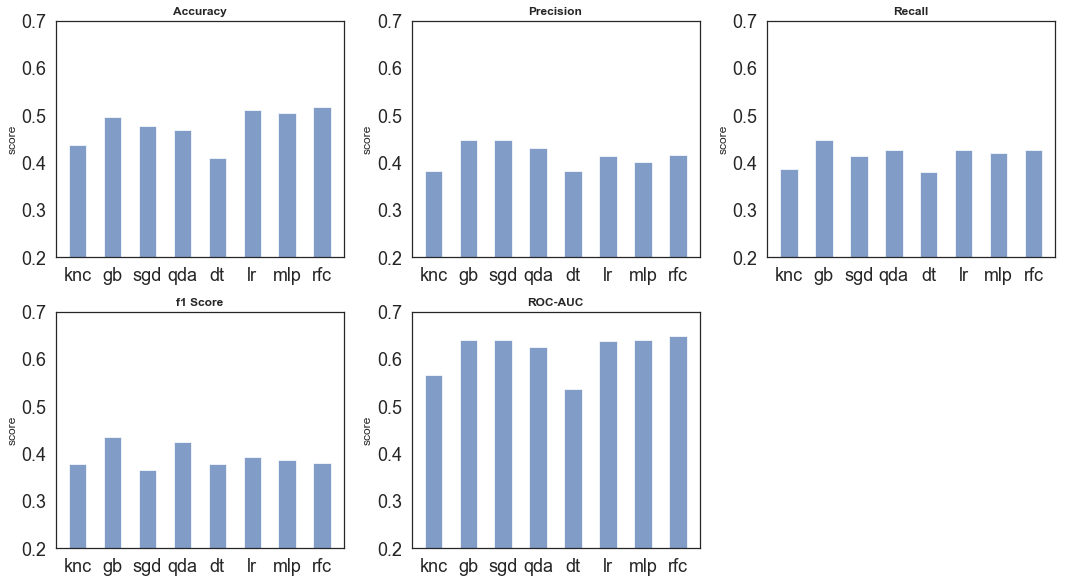

In [349]:
# TODO: consider ploting both performances together for comparison
socres_all = scores_all_testset
x = list(models_dict.keys())
y_pos = np.arange(len(x))

scores_types = {'Accuracy':'test_accuracy',
                'Precision':'test_precision_macro',
                'Recall':'test_recall_macro',
                'f1 Score':'test_f1_macro',
                'ROC-AUC': 'test_roc_auc_ovr',
               }

y_vals_lst = [[scores[vals].mean() for scores in scores_all] for vals in scores_types.values()]

fig = plt.figure()
for typ, num in zip(scores_types.keys(), range(1, len(scores_types) + 1)):
    y_vals = y_vals_lst[num-1]
    ax = fig.add_subplot(5,3,num)
    ax.bar(y_pos, y_vals, align='center', alpha=0.7, width = 0.5)
    
    fig.set_figheight(20)
    fig.set_figwidth(15)

    ax.set_title(typ)
    plt.ylim([0.2,0.7])
    
    plt.xticks(y_pos, x)
    plt.ylabel('score')

plt.tight_layout()
plt.show()

So far, we haven't tested the models on novel inputs. Recall the test set was splitted from the whole data set with the engineered features. However, the novel inputs don't have these well engineered features, they have two team names only: the Home team and the Away team.

From the very previous section, I briefly talked about our current solution: perform a lookup for the recent matchups' performance, and assume the performance has relationship with the novel inputs. Let's test how good it can work.

In [350]:
X_train

,HAS,HDS,HCON,HAGG,AAS,ADS,ACON,AAGG,FFPTSH,FFHG,FFAG,PSH,SSH,CSH,PSA,SSA,CSA
2176,0.618037,0.053942,0.590579,0.310579,0.524851,0.415575,0.084530,0.778200,1.000000,0.400000,0.166667,0.200000,0.140351,0.483333,0.244444,0.283333,0.633333
816,0.452255,0.657676,0.212085,0.085409,0.188072,0.740611,0.308306,0.807605,0.000000,0.050000,0.291667,0.200000,0.245614,0.566667,0.644444,0.383333,0.300000
2222,0.446002,0.347955,0.264435,0.514489,0.642942,0.519651,0.212582,0.539924,0.600000,0.360000,0.133333,0.288889,0.192982,0.366667,0.311111,0.316667,0.433333
1185,0.252874,0.437068,0.152550,0.702254,0.904573,0.196507,0.553792,0.438991,0.333333,0.320000,0.333333,0.444444,0.403509,0.333333,0.755556,0.533333,0.200000
776,1.000000,0.008299,0.563351,0.399871,0.284294,0.731004,0.278288,0.348289,0.250000,0.200000,0.500000,0.266667,0.192982,0.566667,0.755556,0.850000,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.433498,0.510966,0.743616,0.339603,0.492048,0.795852,0.182557,0.000000,0.600000,0.280000,0.166667,0.288889,0.315789,0.400000,0.288889,0.250000,0.466667
466,0.411730,0.452282,0.466404,0.521945,0.382704,0.687773,0.793053,1.000000,0.544657,0.311005,0.195136,0.259259,0.175439,0.305556,0.444444,0.350000,0.400000
3092,0.570292,0.244813,0.531177,0.526690,0.382704,0.975983,0.899240,0.927757,0.333333,0.120000,0.133333,0.577778,0.543860,0.350000,0.333333,0.216667,0.350000
3772,0.452255,0.657676,0.212085,0.085409,0.904573,0.196507,0.553792,0.438991,0.266667,0.240000,0.400000,0.400000,0.403509,0.466667,0.777778,0.633333,0.216667
